In [1]:
#https://towardsdatascience.com/data-exploration-with-adversarial-autoencoders-311a4e1f271b
import pandas as pd
import numpy as np
import tensorflow as tf
import h5py
import keras
from keras import Model, Sequential
from keras.layers import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.utils import to_categorical
from keras.optimizers import Nadam
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, TensorBoard
from keras import backend as K
from os import listdir
import seaborn as sns
from tqdm import tqdm
import torch
import glob
import math

from keras.utils.vis_utils import plot_model
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz 2.44.1/bin/'

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

#some stats for the unstructured dataset
jointMeans = [ 9.14982540e-01, -5.57923141e-01,  8.58194099e+00,  3.97530284e-01,
       -2.75233517e-01,  2.39274380e-02,  3.97521941e-01, -2.75248874e-01,
        3.81468753e+00,  3.01834808e-01, -1.95755853e-01,  6.66328151e+00,
       -1.46556269e+00, -6.45884522e-01,  1.78234918e+01, -2.89338041e+00,
       -7.06155534e-01, -3.06842586e+00, -3.88548529e+00,  2.49349467e+00,
       -3.84020964e+00,  1.69685072e+01,  7.69466709e+00,  3.03574202e+01,
       -1.87888355e+01,  8.05162624e+01,  5.37066871e+01,  4.25680264e+00,
       -2.40432863e+00, -1.12424281e+01, -9.20431037e+00, -1.56030651e-01,
       -6.85954946e-01,  1.65933537e+01,  9.86648041e+00,  2.59459165e+01,
       -1.79494344e+01,  7.48534138e+01,  5.75162114e+01,  2.78185577e+00,
       -2.82982243e+00, -7.73781232e+00,  2.83078114e-01, -5.28279397e+00,
        2.38722351e+01,  5.11016153e-01, -1.11771111e-01,  3.30879725e+01,
       -3.76676132e+00, -4.93506460e+00,  3.46075926e-01,  2.55396139e-01,
       -1.88380464e-02, -4.35061707e+00,  9.18342144e-01, -4.56721809e+00,
        2.50936774e+01,  1.23978922e-01, -4.51519003e-01,  3.59859526e+01,
       -4.47245222e+00, -3.20725701e+00,  1.16098368e+00,  6.31001977e-01,
        1.62218117e-01, -4.74804745e+00]

jointSTDs = [ 2.50769901,  2.89007328,  4.82135627,  1.09555453,  1.30328335,
        2.14172372,  1.09554141,  1.30329462,  2.14218764,  0.830996  ,
        0.97001108,  1.61093696,  4.19080449,  6.76506471,  4.84207178,
        6.16379998, 13.43315227,  8.9700052 ,  4.10752205,  4.53511891,
        4.86198016, 10.17279726, 15.33646364, 21.58296053, 16.32272061,
       29.76842195, 32.89011385, 13.18560507,  9.57721836, 15.69166059,
        3.87651068,  4.37787549,  4.98784298,  9.57856384, 16.23952042,
       22.12710705, 15.26502725, 28.89684133, 34.00353878, 14.30201682,
        9.81932319, 16.70823703,  6.52667298,  7.98732672, 19.44770783,
        3.75892505,  4.75493904, 20.53642448,  7.23816215, 10.43597269,
        9.72810384,  4.37845825,  1.25844709,  9.66427248,  6.20870119,
        7.46777365, 19.73792051,  3.57618016,  4.07928902, 20.12362033,
        7.26039667, 10.74356634, 10.38937948,  4.40461265,  1.43114816,
        9.88812903]

jointLabels = ['ang_jL5S1_Frontal', 'ang_jL5S1_Trans', 'ang_jL5S1_Sagittal', 'ang_jL4L3_Frontal', 
               'ang_jL4L3_Trans', 'ang_jL4L3_Sagittal', 'ang_jL1T12_Frontal', 'ang_jL1T12_Trans',
               'ang_jL1T12_Sagittal', 'ang_jT9T8_Frontal', 'ang_jT9T8_Trans', 'ang_jT9T8_Sagittal',
               'ang_jT1C7_Frontal', 'ang_jT1C7_Trans', 'ang_jT1C7_Sagittal', 'ang_jC1Head_Frontal',
               'ang_jC1Head_Trans', 'ang_jC1Head_Sagittal', 'ang_jRightT4Shoulder_Frontal', 
               'ang_jRightT4Shoulder_Trans', 'ang_jRightT4Shoulder_Sagittal', 'ang_jRightShoulder_Frontal',
               'ang_jRightShoulder_Trans', 'ang_jRightShoulder_Sagittal', 'ang_jRightElbow_Frontal', 
               'ang_jRightElbow_Trans', 'ang_jRightElbow_Sagittal', 'ang_jRightWrist_Frontal',
               'ang_jRightWrist_Trans', 'ang_jRightWrist_Sagittal', 'ang_jLeftT4Shoulder_Frontal',
               'ang_jLeftT4Shoulder_Trans', 'ang_jLeftT4Shoulder_Sagittal', 'ang_jLeftShoulder_Frontal', 
               'ang_jLeftShoulder_Trans', 'ang_jLeftShoulder_Sagittal', 'ang_jLeftElbow_Frontal', 
               'ang_jLeftElbow_Trans', 'ang_jLeftElbow_Sagittal', 'ang_jLeftWrist_Frontal', 'ang_jLeftWrist_Trans', 
               'ang_jLeftWrist_Sagittal', 'ang_jRightHip_Frontal', 'ang_jRightHip_Trans',
               'ang_jRightHip_Sagittal', 'ang_jRightKnee_Frontal', 'ang_jRightKnee_Trans', 
               'ang_jRightKnee_Sagittal', 'ang_jRightAnkle_Frontal', 'ang_jRightAnkle_Trans', 
               'ang_jRightAnkle_Sagittal', 'ang_jRightBallFoot_Frontal', 'ang_jRightBallFoot_Trans', 
               'ang_jRightBallFoot_Sagittal', 'ang_jLeftHip_Frontal', 'ang_jLeftHip_Trans', 
               'ang_jLeftHip_Sagittal', 'ang_jLeftKnee_Frontal', 'ang_jLeftKnee_Trans', 'ang_jLeftKnee_Sagittal', 
               'ang_jLeftAnkle_Frontal', 'ang_jLeftAnkle_Trans', 'ang_jLeftAnkle_Sagittal', 
               'ang_jLeftBallFoot_Frontal', 'ang_jLeftBallFoot_Trans', 'ang_jLeftBallFoot_Sagittal']

# Import data

### Flatground

In [2]:
legs = [42, 43, 44, 47, 48, 49, 50, 54, 55, 56, 59, 60, 61, 62]
dataset = h5py.File(r'Z:\uncompressed-dataset\special\train-flat-subjects-cadence.hdf5', 'r')
x_train = []
temp = []
currentKey = '11'
for key in dataset.keys():
    if key.split('-')[0] == currentKey:
        temp.append(dataset[key][:,:,:])
    else:
        temp = np.vstack(temp)
        x_train.append(temp)
        temp = []
        temp.append(dataset[key][:,:,:])
    currentKey = key.split('-')[0]
temp = np.vstack(temp)
x_train.append(temp)
x_train_flat_all = x_train.copy()
indices = []
indices.append(0)
for s in range(len(x_train)):
    skipFrames = np.arange(0,x_train[s].shape[0],10)
    x_train[s] = x_train[s][skipFrames]
    print(x_train[s].shape)
    indices.append(x_train[s].shape[0])
indices = np.cumsum(indices)
x_train_flat = np.vstack(x_train)
print(x_train_flat.shape)
print(indices)

(1590, 60, 15)
(3403, 60, 15)
(1955, 60, 15)
(5145, 60, 15)
(5844, 60, 15)
(1252, 60, 15)
(7884, 60, 15)
(8323, 60, 15)
(35396, 60, 15)
[    0  1590  4993  6948 12093 17937 19189 27073 35396]


### Stairs

In [174]:
legs = [42, 43, 44, 47, 48, 49, 50, 54, 55, 56, 59, 60, 61, 62]
dataset = h5py.File(r'Z:\uncompressed-dataset\special\train2-stairs-legs.hdf5', 'r')
x_train = []
for key in dataset.keys():
    x_train.append(dataset[key][:,:,:]) 
x_train = np.array(x_train[0])
skipFrames = np.arange(0,x_train.shape[0],10)
x_train_stairs = x_train[skipFrames,:,:]


dataset = h5py.File(r'Z:\uncompressed-dataset\special\test2-stairs-legs.hdf5', 'r')
x_test = []
for key in dataset.keys():
    x_test.append(dataset[key][:,:,:]) 
x_test = np.array(x_test[0])
skipFrames = np.arange(0,x_test.shape[0],10)
x_test_stairs = x_test[skipFrames,:,:]


print(x_train_stairs.shape)
print(x_test_stairs.shape)

(54755, 60, 14)
(12326, 60, 14)


# Functions

In [3]:
def create_movement_encoder(latent_dim, window_size, input_dim):
    input_layer = Input(shape=(window_size, input_dim))
    
    code = TimeDistributed(Dense(64, activation='linear'))(input_layer)
    code = Bidirectional(LSTM(128, return_sequences=True))(input_layer)
    code = BatchNormalization()(code)
    code = ELU()(code)
    code = Bidirectional(LSTM(64))(code)
    code = BatchNormalization()(code)
    code = ELU()(code)
    
    latent_repr = Dense(64)(code)
    latent_repr = BatchNormalization()(latent_repr)
    latent_repr = PReLU()(latent_repr)
    latent_repr = Dense(latent_dim, activation='linear')(latent_repr)
    
    decode = RepeatVector(window_size)(latent_repr)
    decode = Bidirectional(LSTM(64, return_sequences=True))(decode)
    decode = ELU()(decode)
    decode = Bidirectional(LSTM(128, return_sequences=True))(decode)
    decode = ELU()(decode)
    decode = TimeDistributed(Dense(64))(decode)
    decode = ELU()(decode)
    decode = TimeDistributed(Dense(input_dim, activation='linear'))(decode)
    
    error = Subtract()([input_layer, decode])
        
    return Model(input_layer, [decode, latent_repr, error])

def create_pose_encoder(latent_dim, input_dim):
    input_layer = Input(shape=(input_dim))
    
    encoder = Dense(28, activation = 'tanh')(input_layer)
    encoder = BatchNormalization()(encoder)
    encoder = Dense(14, activation = 'tanh')(encoder)
    encoder = BatchNormalization()(encoder)
    encoder = Dense(7, activation = 'tanh')(encoder)
    
    latent = Dense(latent_dim, activation = 'linear')(encoder)
    
    decoder = Dense(7, activation = 'tanh')(latent)
    decoder = Dense(14, activation = 'tanh')(decoder)
    decoder = Dense(14, activation = 'linear')(decoder)
    
    error = Subtract()([input_layer, decoder])
    
    return Model(input_layer, [decoder, latent, error])

### Build movement encoder

In [69]:
window_size = 60
input_dim = 14
latent_dim = 2

#create encoder given input shape
encoder = create_movement_encoder(latent_dim, window_size, input_dim)

#initialize inputs
signal_in = Input(shape=(window_size, input_dim))

reconstructed_signal, encoded_repr, _ = encoder(signal_in)

autoencoder = Model(signal_in, [reconstructed_signal])
autoencoder.compile(loss='mse', optimizer='Adam')

### Train movement encoder

In [70]:
batches = 2000
batch_size=32

losses = []
losses_val = []

pbar = tqdm(range(batches))
for _ in pbar:
    ids = np.random.randint(0, x_train[0].shape[0]/2, batch_size)
    x_signals = x_train[0][ids]
    y_signals = x_signals

    encoder_loss = autoencoder.train_on_batch(x_signals, [y_signals])
    losses.append(encoder_loss)

    val_loss = autoencoder.test_on_batch(x_train[0][795:], x_train[0][795:])
    losses_val.append(val_loss)
print(losses_val[-1])

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:42<00:00, 12.28it/s]


0.05474939942359924


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:45<00:00, 12.10it/s]


0.05408798158168793


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:44<00:00, 12.14it/s]


0.05060224607586861


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:45<00:00, 12.06it/s]


0.05199441313743591


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:45<00:00, 12.11it/s]


0.05195017531514168


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:44<00:00, 12.18it/s]


0.05086448788642883


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:45<00:00, 12.10it/s]


0.05997265875339508


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:44<00:00, 12.16it/s]


0.05403478816151619


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:45<00:00, 12.08it/s]


0.05022362247109413


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:47<00:00, 11.95it/s]

0.04923058673739433


In [29]:
print(losses_val[-1])

0.05264555290341377


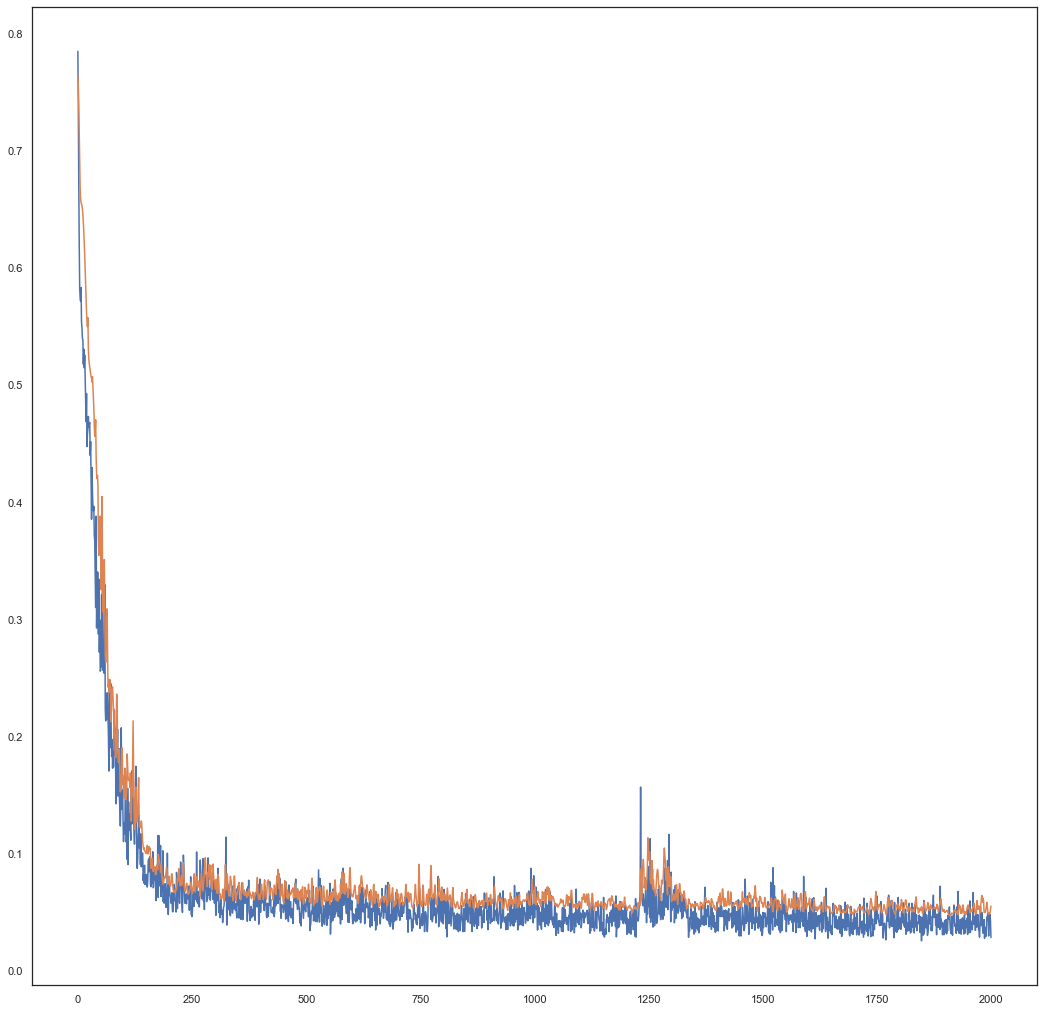

In [67]:
plt.plot(losses)
plt.plot(losses_val)

In [13]:
(dec, rep, error) = encoder.predict(x_train_flat[:,:,:])

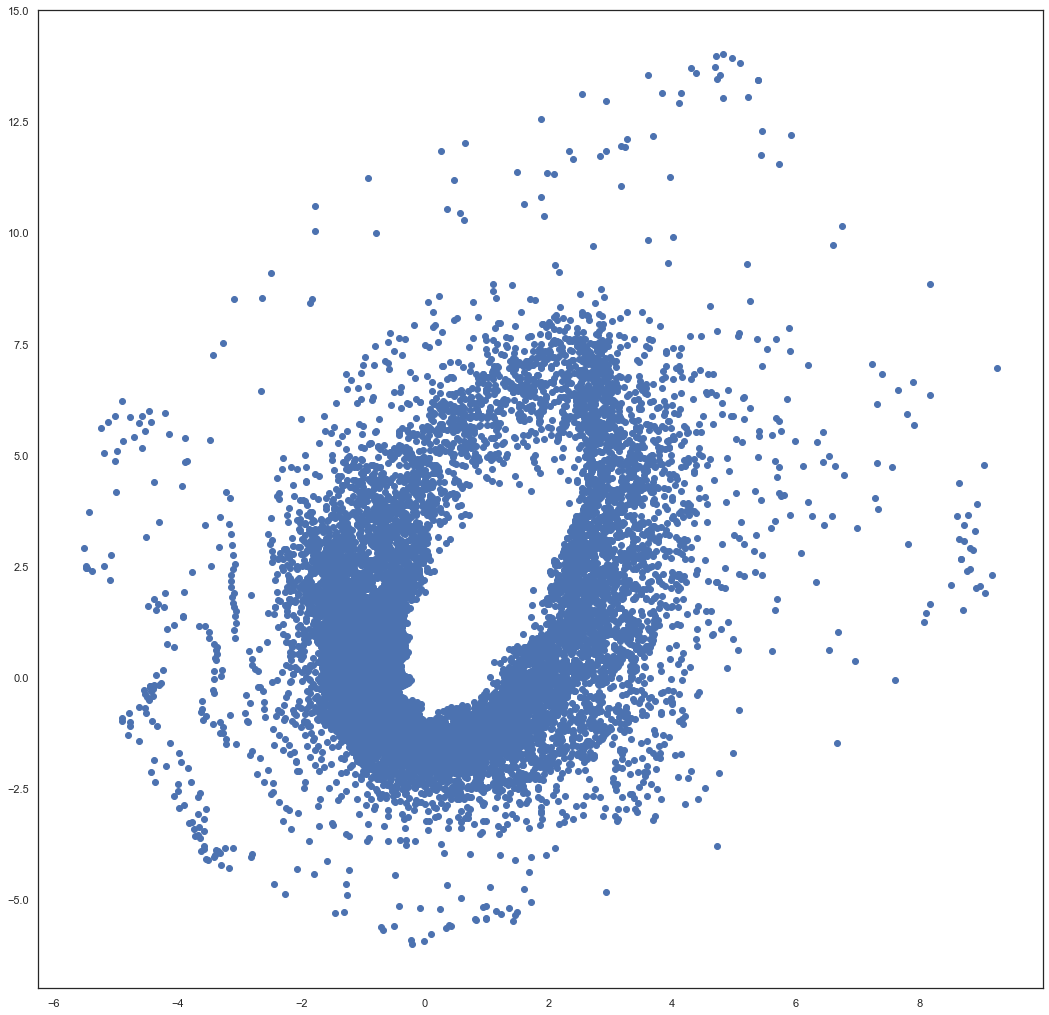

In [18]:
(dec, rep, error) = encoder.predict(x_train_flat_all[0][:,:,:])
plt.scatter(rep[:,0],rep[:,1])

### Visualization

Text(0.5, 1.0, 'Flat ground adversarial model latent space colored by subject')

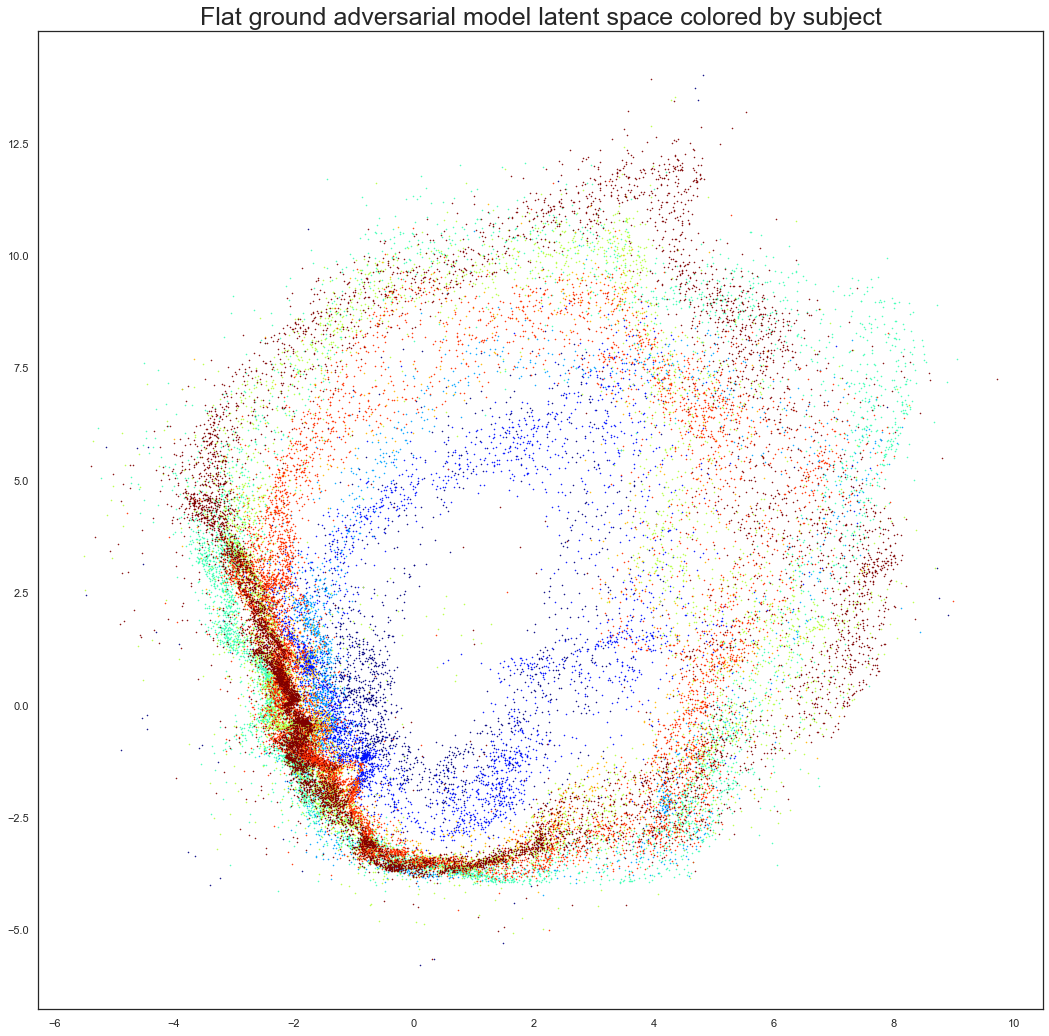

In [14]:
### Basic
sns.set(style='white', context='notebook', rc={'figure.figsize':(18,18)})

colors = plt.cm.jet(np.linspace(0,1,8))

fig, ax = plt.subplots()

for sub in range(len(indices)-1):
    #(dec, rep, rep2, cat, error) = encoder.predict(x_train_flat[sub])
    ax.scatter(x = rep[indices[sub]:indices[sub+1],0], y = rep[indices[sub]:indices[sub+1],1], label = sub, alpha = 1, s = 0.3, color = colors[sub])
    #ax.scatter(x = rep[:,0], y = rep[:,1], label = sub, alpha = 1, s = 0.1, color = colors[sub])
#ax.legend(fontsize = 25, markerscale=50)
plt.title("Flat ground adversarial model latent space colored by subject", fontsize = 25)
#ax.scatter(reps[-1][standing,0], reps[-1][standing,1], alpha = 1, s = 3, color = 'black')

# Movement Separability

In [176]:
#Generate mixed dataset
mixedTrain = np.vstack([x_train_flat[:,:,:-1], x_train_stairs])
print(x_train_flat.shape)
print(x_train_stairs.shape)
print(mixedTrain.shape)

(35396, 60, 15)
(54755, 60, 14)
(90151, 60, 14)


## Movement Autoencoder

In [179]:
from sklearn import svm

#Train standard model on whole training dataset
#Generate embedding
#Perform SVM to classify each subject
window_size = 60
input_dim = 14
latent_dim = 2

losses = []
losses_val = []
allRepsMC = []
allErrorsMC = []

for r in range(10):
    #create encoder given input shape
    encoder = create_movement_encoder(latent_dim, window_size, input_dim)

    #initialize inputs
    signal_in = Input(shape=(window_size, input_dim))

    reconstructed_signal, encoded_repr, _ = encoder(signal_in)

    autoencoder = Model(signal_in, [reconstructed_signal])
    autoencoder.compile(loss='mse', optimizer='Adam')

    batches = 8000
    batch_size=32

    losses = []
    losses_val = []

    pbar = tqdm(range(batches))
    for _ in pbar:
        ids = np.random.randint(0, mixedTrain.shape[0], batch_size)
        x_signals = mixedTrain[ids,:,:]
        y_signals = x_signals

        encoder_loss = autoencoder.train_on_batch(x_signals, y_signals)
        losses.append(encoder_loss)

        #val_loss = autoencoder.test_on_batch(x_signals, y_signals)
        #losses_val.append(val_loss)
    
    (dec, rep, error) = encoder.predict(mixedTrain[:,:,:])

    labels = np.concatenate([np.full(x_train_flat.shape[0], 0), np.full(x_train_stairs.shape[0], 1)])

    clf = svm.SVC()
    clf.fit(rep, labels)

    preds = clf.predict(rep)

    errorIdx = []
    errorCount = 0
    for p in range(preds.shape[0]):
        if preds[p] != labels[p]:
            errorCount += 1
            errorIdx.append(p)

    print(errorCount / labels.shape[0])
    allRepsMC.append(rep)
    allErrorsMC.append(errorCount / labels.shape[0])

100%|██████████████████████████████████████████████████████████████████████████████| 8000/8000 [05:24<00:00, 24.65it/s]


0.016782953045445973


100%|██████████████████████████████████████████████████████████████████████████████| 8000/8000 [05:28<00:00, 24.38it/s]


0.03992190879746203


100%|██████████████████████████████████████████████████████████████████████████████| 8000/8000 [05:28<00:00, 24.34it/s]


0.08098634513205621


100%|██████████████████████████████████████████████████████████████████████████████| 8000/8000 [05:20<00:00, 24.99it/s]


0.026289225854399842


100%|██████████████████████████████████████████████████████████████████████████████| 8000/8000 [05:09<00:00, 25.86it/s]


0.02738738339008996


100%|██████████████████████████████████████████████████████████████████████████████| 8000/8000 [05:30<00:00, 24.20it/s]


0.0075539927455047645


100%|██████████████████████████████████████████████████████████████████████████████| 8000/8000 [05:30<00:00, 24.21it/s]


0.04054308881765039


100%|██████████████████████████████████████████████████████████████████████████████| 8000/8000 [05:08<00:00, 25.91it/s]


0.03396523610387017


100%|██████████████████████████████████████████████████████████████████████████████| 8000/8000 [05:35<00:00, 23.83it/s]


0.009217867799580703


100%|██████████████████████████████████████████████████████████████████████████████| 8000/8000 [05:28<00:00, 24.36it/s]


0.046910184024580984


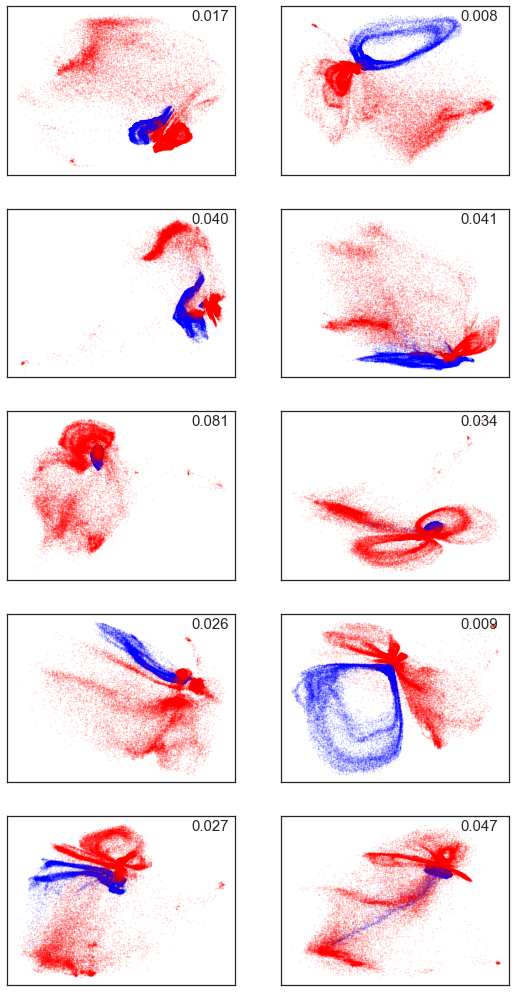

In [186]:
sns.set(style='white', context='notebook', rc={'figure.figsize':(9,18)})
fig, axs = plt.subplots(5,2)
colors = plt.cm.Spectral(np.linspace(0,1,8))
for r in range(5):
    axs[r,0].set_title('{0:.3f}'.format(allErrorsMC[r]), loc = 'right', y=1.0, x = 0.97, pad=-14, fontsize = 15)
    axs[r,0].get_xaxis().set_visible(False)
    axs[r,0].get_yaxis().set_visible(False)
    axs[r,0].scatter(allRepsMC[r][:x_train_flat.shape[0],0], y = allRepsMC[r][:x_train_flat.shape[0],1], alpha = 0.1, s = 0.3, color = 'blue')
    axs[r,0].scatter(allRepsMC[r][x_train_flat.shape[0]:,0], y = allRepsMC[r][x_train_flat.shape[0]:,1], alpha = 0.1, s = 0.3, color = 'red')
for r in range(5):
    axs[r,1].set_title('{0:.3f}'.format(allErrorsMC[r+5]), loc = 'right', y=1.0, x = 0.95, pad=-14, fontsize = 15)
    axs[r,1].get_xaxis().set_visible(False)
    axs[r,1].get_yaxis().set_visible(False)
    axs[r,1].scatter(allRepsMC[r+5][:x_train_flat.shape[0],0], y = allRepsMC[r+5][:x_train_flat.shape[0],1], alpha = 0.1, s = 0.3, color = 'blue')
    axs[r,1].scatter(allRepsMC[r+5][x_train_flat.shape[0]:,0], y = allRepsMC[r+5][x_train_flat.shape[0]:,1], alpha = 0.1, s = 0.3, color = 'red')
#plt.legend(fontsize = 25, markerscale=50, loc = 'right')
#plt.legend(bbox_to_anchor=(1.6, 5.85), fontsize = 25, markerscale=50, loc='upper right', ncol=1)
plt.savefig('figs/MoveAE-10runs-MoveColor.png')

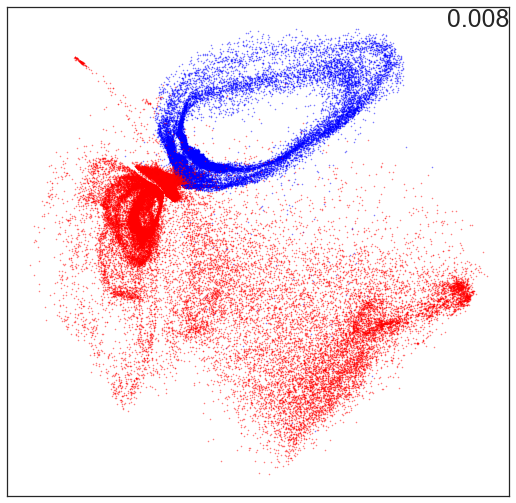

In [209]:
sns.set(style='white', context='notebook', rc={'figure.figsize':(9,9)})
plt.title('{0:.3f}'.format(allErrorsMC[5]), loc = 'right', y=1, x = 1, pad=-20, fontsize = 25)
frame1 = plt.gca()
frame1.axes.get_xaxis().set_visible(False)
frame1.axes.get_yaxis().set_visible(False)
plt.scatter(allRepsMC[5][:x_train_flat.shape[0],0], y = allRepsMC[5][:x_train_flat.shape[0],1], alpha = 0.5, s = 0.3, color = 'blue')
plt.scatter(allRepsMC[5][x_train_flat.shape[0]:,0], y = allRepsMC[5][x_train_flat.shape[0]:,1], alpha = 0.5, s = 0.3, color = 'red')
plt.savefig('figs/BestMove-MC.png')

## Pose Autoencoder

In [185]:
from sklearn import svm

#Train standard model on whole training dataset
#Generate embedding
#Perform SVM to classify each subject
input_dim = 14
latent_dim = 2

losses = []
losses_val = []
allRepsMC2 = []
allErrorsMC2 = []

for r in range(10):
    #create encoder given input shape
    encoder = create_pose_encoder(latent_dim, input_dim)

    #initialize inputs
    signal_in = Input(shape=input_dim)

    reconstructed_signal, encoded_repr, _ = encoder(signal_in)

    autoencoder = Model(signal_in, [reconstructed_signal])
    autoencoder.compile(loss='mse', optimizer='Adam')

    batches = 8000
    batch_size=32

    losses = []
    losses_val = []

    pbar = tqdm(range(batches))
    for _ in pbar:
        ids = np.random.randint(0, mixedTrain.shape[0], batch_size)
        x_signals = mixedTrain[ids,0,:]
        y_signals = x_signals

        encoder_loss = autoencoder.train_on_batch(x_signals, y_signals)
        losses.append(encoder_loss)

        #val_loss = autoencoder.test_on_batch(x_signals, y_signals)
        #losses_val.append(val_loss)
    
    (dec, rep, error) = encoder.predict(mixedTrain[:,0,:])

    labels = np.concatenate([np.full(x_train_flat.shape[0], 0), np.full(x_train_stairs.shape[0], 1)])

    clf = svm.SVC()
    clf.fit(rep, labels)

    preds = clf.predict(rep)

    errorIdx = []
    errorCount = 0
    for p in range(preds.shape[0]):
        if preds[p] != labels[p]:
            errorCount += 1
            errorIdx.append(p)

    print(errorCount / labels.shape[0])
    allRepsMC2.append(rep)
    allErrorsMC2.append(errorCount / labels.shape[0])

  0%|                                                                                         | 0/8000 [00:00<?, ?it/s]

0.09900056571751839


  0%|                                                                                         | 0/8000 [00:00<?, ?it/s]

0.1658106953888476


  0%|                                                                                         | 0/8000 [00:00<?, ?it/s]

0.08299408769730784


  0%|                                                                                         | 0/8000 [00:00<?, ?it/s]

0.18427970848909053


  0%|                                                                                         | 0/8000 [00:00<?, ?it/s]

0.15381970249914034


  0%|                                                                                         | 0/8000 [00:00<?, ?it/s]

0.11578351876296436


  0%|                                                                                         | 0/8000 [00:00<?, ?it/s]

0.0929995230224845


  0%|                                                                                         | 0/8000 [00:00<?, ?it/s]

0.09633836563099689


  0%|                                                                                         | 0/8000 [00:00<?, ?it/s]

0.10121906578961964


100%|█████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:35<00:00, 223.27it/s]


0.08734234783862631


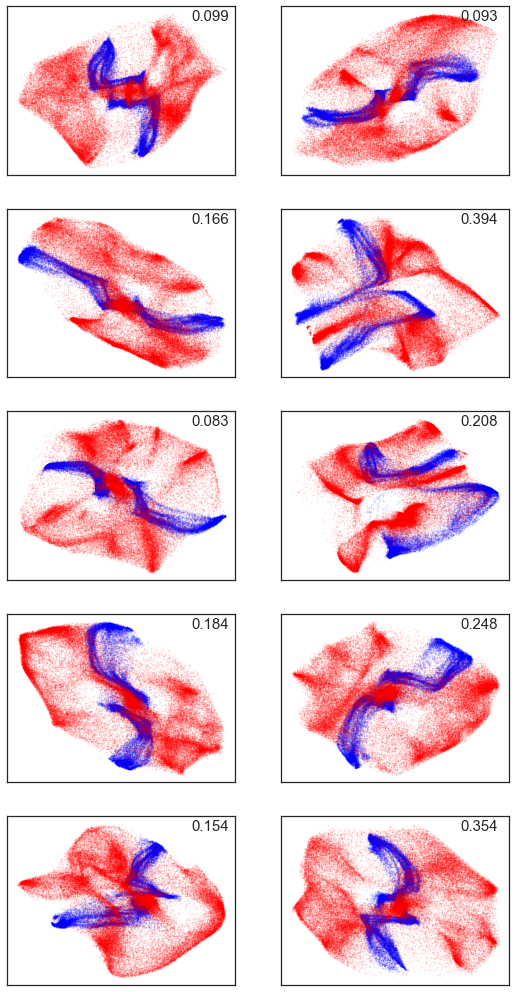

In [201]:
sns.set(style='white', context='notebook', rc={'figure.figsize':(9,18)})
fig, axs = plt.subplots(5,2)
colors = plt.cm.Spectral(np.linspace(0,1,8))
for r in range(5):
    axs[r,0].set_title('{0:.3f}'.format(allErrorsMC2[r]), loc = 'right', y=1.0, x = 0.97, pad=-14, fontsize = 15)
    axs[r,0].get_xaxis().set_visible(False)
    axs[r,0].get_yaxis().set_visible(False)
    axs[r,0].scatter(allRepsMC2[r][:x_train_flat.shape[0],0], y = allRepsMC2[r][:x_train_flat.shape[0],1], alpha = 0.1, s = 0.3, color = 'blue')
    axs[r,0].scatter(allRepsMC2[r][x_train_flat.shape[0]:,0], y = allRepsMC2[r][x_train_flat.shape[0]:,1], alpha = 0.1, s = 0.3, color = 'red')
for r in range(5):
    axs[r,1].set_title('{0:.3f}'.format(allErrors[r+5]), loc = 'right', y=1.0, x = 0.95, pad=-14, fontsize = 15)
    axs[r,1].get_xaxis().set_visible(False)
    axs[r,1].get_yaxis().set_visible(False)
    axs[r,1].scatter(allRepsMC2[r+5][:x_train_flat.shape[0],0], y = allRepsMC2[r+5][:x_train_flat.shape[0],1], alpha = 0.1, s = 0.3, color = 'blue')
    axs[r,1].scatter(allRepsMC2[r+5][x_train_flat.shape[0]:,0], y = allRepsMC2[r+5][x_train_flat.shape[0]:,1], alpha = 0.1, s = 0.3, color = 'red')
#plt.legend(fontsize = 25, markerscale=50, loc = 'right')
#plt.legend(labels = ['flat','stairs'], bbox_to_anchor=(2, 5.85), fontsize = 25, markerscale=50, loc='upper right', ncol=1)
plt.savefig('figs/PoseAE-10runs-MoveColor.png')

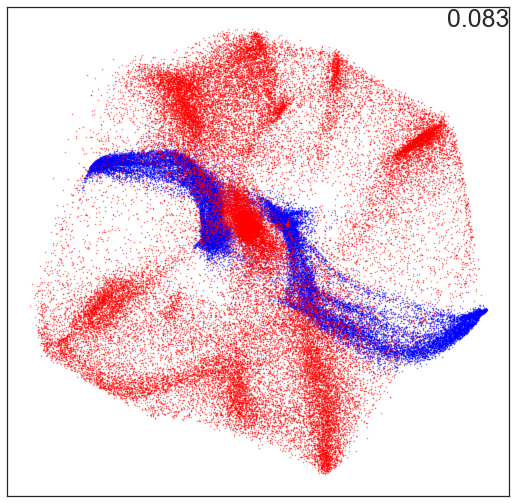

In [210]:
sns.set(style='white', context='notebook', rc={'figure.figsize':(9,9)})
plt.title('{0:.3f}'.format(allErrorsMC2[2]), loc = 'right', y=1, x = 1, pad=-20, fontsize = 25)
frame1 = plt.gca()
frame1.axes.get_xaxis().set_visible(False)
frame1.axes.get_yaxis().set_visible(False)
plt.scatter(allRepsMC2[2][:x_train_flat.shape[0],0], y = allRepsMC2[2][:x_train_flat.shape[0],1], alpha = 0.5, s = 0.3, color = 'blue')
plt.scatter(allRepsMC2[2][x_train_flat.shape[0]:,0], y = allRepsMC2[2][x_train_flat.shape[0]:,1], alpha = 0.5, s = 0.3, color = 'red')
plt.savefig('figs/BestPose-MC.png')

## PCA

In [190]:
from sklearn.decomposition import PCA # for PCA calculation

pca_vaf_train = []
pca_vaf_test = []
pca_reconLoss = []
pca = PCA()

rep = pca.fit_transform(mixedTrain[:,0,:])
y_pca = pca.inverse_transform(rep)

from sklearn import svm

labels = np.concatenate([np.full(x_train_flat.shape[0], 0), np.full(x_train_stairs.shape[0], 1)])
clf = svm.SVC()
clf.fit(rep[:,:2], labels)

preds = clf.predict(rep[:,:2])

errorIdx = []
errorCount = 0
for p in range(preds.shape[0]):
    if preds[p] != labels[p]:
        errorCount += 1
        errorIdx.append(p)

print(errorCount / labels.shape[0])

0.21835586959656575


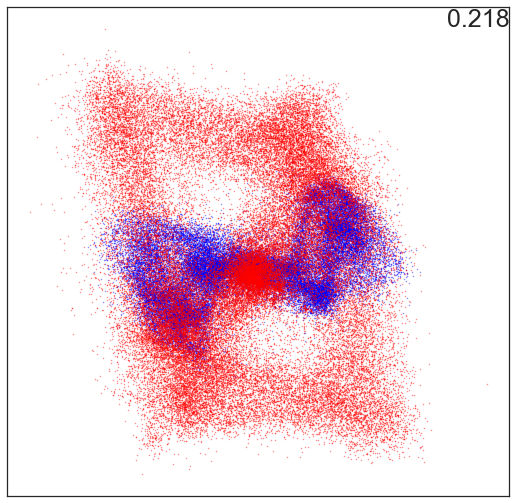

In [214]:
sns.set(style='white', context='notebook', rc={'figure.figsize':(9,9)})
plt.title('0.218', loc = 'right', y=1, x = 1, pad=-20, fontsize = 25)
plt.scatter(rep[:x_train_flat.shape[0],0], rep[:x_train_flat.shape[0],1], alpha = 0.5, s=0.2, color = 'blue')
plt.scatter(rep[x_train_flat.shape[0]:,0], rep[x_train_flat.shape[0]:,1], alpha = 0.5, s=0.2, color = 'red')
frame1 = plt.gca()
frame1.axes.get_xaxis().set_visible(False)
frame1.axes.get_yaxis().set_visible(False)
#plt.title('{0:.3f}'.format(0.2183), loc = 'right', y=1.0, x = 0.95, pad=-14, fontsize = 15)
plt.savefig('figs/PCA-1runs-MoveColor.png')
#plt.scatter(rep[errorIdx,0], rep[errorIdx,1], s = 3, color = 'purple')

## Movement Separability Figure

Kolmogorov-Smirnov statistic returns p value of: 0.00001


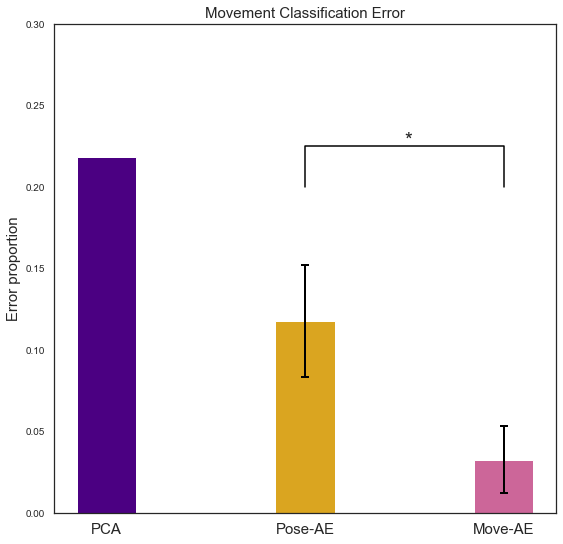

In [240]:
from scipy import stats


heights = [0.2184, np.mean(allErrorsMC2), np.mean(allErrorsMC)]
stds = [0, np.std(allErrorsMC2), np.std(allErrorsMC)]
plt.ylim(0,0.3)
plt.bar('PCA', heights[0], width = 0.3, align='center', color = 'indigo');
plt.bar('Pose-AE', heights[1], width = 0.3, align='center', color = 'goldenrod');
plt.bar('Move-AE', heights[2], width = 0.3, align='center', color = (0.8,0.4,0.6));
plt.errorbar([1,2], heights[1:], stds[1:], capsize = 4, capthick = 2, linewidth = 2, linestyle='None', color = 'black', barsabove =False);
plt.xticks(fontsize=15);
plt.yticks(fontsize=10);
plt.ylabel('Error proportion', fontsize = 15)
plt.title('Movement Classification Error', fontsize = 15)

plt.plot([1, 1, 2, 2], [0.2, 0.225, 0.225, 0.2], color = 'black')
plt.annotate('*', (1.5, 0.225), fontsize = 20)

stat, pvalue = stats.ks_2samp(allErrorsMC, allErrorsMC2)
print('Kolmogorov-Smirnov statistic returns p value of: ' + '{0:.5f}'.format(pvalue))
#plt.savefig('figs/Barchart-Move.png')

In [241]:
print(heights)
print(stds)

[0.2184, 0.11795875808365966, 0.032955818571064104]
[0, 0.034451332715973525, 0.020382647948082706]


# Individual Identification

## Movement Autoencoder

In [32]:
from sklearn import svm

#Train standard model on whole training dataset
#Generate embedding
#Perform SVM to classify each subject
window_size = 60
input_dim = 14
latent_dim = 2

losses = []
losses_val = []
allReps = []
allErrors = []

for r in range(10):
    #create encoder given input shape
    encoder = create_movement_encoder(latent_dim, window_size, input_dim)

    #initialize inputs
    signal_in = Input(shape=(window_size, input_dim))

    reconstructed_signal, encoded_repr, _ = encoder(signal_in)

    autoencoder = Model(signal_in, [reconstructed_signal])
    autoencoder.compile(loss='mse', optimizer='Adam')

    batches = 8000
    batch_size=32

    losses = []
    losses_val = []

    pbar = tqdm(range(batches))
    for _ in pbar:
        ids = np.random.randint(0, x_train_flat.shape[0], batch_size)
        x_signals = x_train_flat[ids,:,:-1]
        y_signals = x_signals

        encoder_loss = autoencoder.train_on_batch(x_signals, y_signals)
        losses.append(encoder_loss)

        #val_loss = autoencoder.test_on_batch(x_signals, y_signals)
        #losses_val.append(val_loss)
    
    (dec, rep, error) = encoder.predict(x_train_flat[:,:,:-1])

    labels = np.empty((0))
    for ind in range(len(x_train)):
        labels = np.concatenate([labels, np.full(x_train[ind].shape[0], ind)])

    clf = svm.SVC()
    clf.fit(rep, labels)

    preds = clf.predict(rep)

    errorIdx = []
    errorCount = 0
    for p in range(preds.shape[0]):
        if preds[p] != labels[p]:
            errorCount += 1
            errorIdx.append(p)

    print(errorCount / labels.shape[0])
    allReps.append(rep)
    allErrors.append(errorCount / labels.shape[0])

100%|██████████████████████████████████████████████████████████████████████████████| 8000/8000 [05:09<00:00, 25.88it/s]


0.31653294157531925


100%|██████████████████████████████████████████████████████████████████████████████| 8000/8000 [05:06<00:00, 26.07it/s]


0.270002260142389


100%|██████████████████████████████████████████████████████████████████████████████| 8000/8000 [05:11<00:00, 25.68it/s]


0.4371115380268957


100%|██████████████████████████████████████████████████████████████████████████████| 8000/8000 [05:30<00:00, 24.19it/s]


0.26649903943948466


100%|██████████████████████████████████████████████████████████████████████████████| 8000/8000 [05:26<00:00, 24.54it/s]


0.3024070516442536


100%|██████████████████████████████████████████████████████████████████████████████| 8000/8000 [05:20<00:00, 24.99it/s]


0.09294835574641203


100%|██████████████████████████████████████████████████████████████████████████████| 8000/8000 [05:31<00:00, 24.12it/s]


0.394366595095491


100%|██████████████████████████████████████████████████████████████████████████████| 8000/8000 [05:26<00:00, 24.52it/s]


0.2075093230873545


100%|██████████████████████████████████████████████████████████████████████████████| 8000/8000 [05:30<00:00, 24.23it/s]


0.24785286473047802


100%|██████████████████████████████████████████████████████████████████████████████| 8000/8000 [05:30<00:00, 24.18it/s]


0.35396654989264326


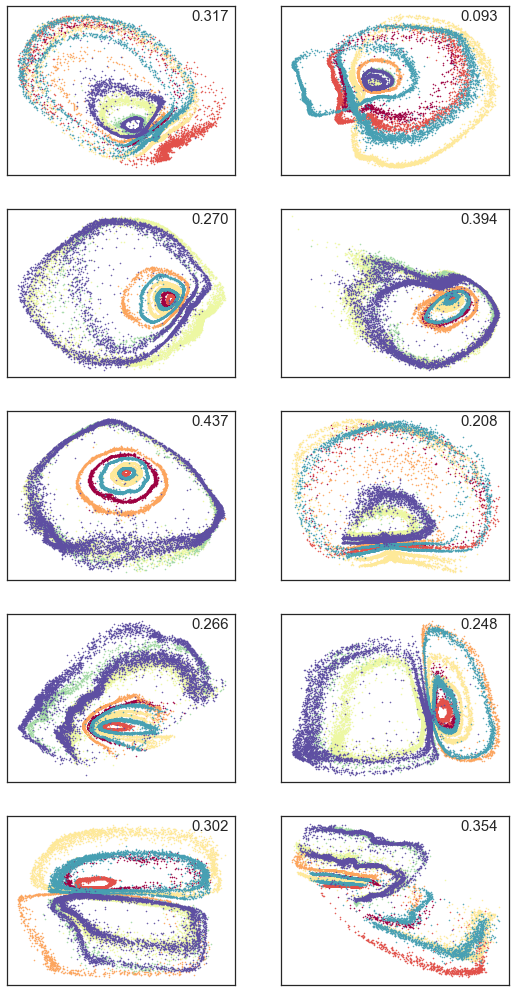

In [99]:
sns.set(style='white', context='notebook', rc={'figure.figsize':(9,18)})
fig, axs = plt.subplots(5,2)
colors = plt.cm.Spectral(np.linspace(0,1,8))
for r in range(5):
    axs[r,0].set_title('{0:.3f}'.format(allErrors[r]), loc = 'right', y=1.0, x = 0.97, pad=-14, fontsize = 15)
    axs[r,0].get_xaxis().set_visible(False)
    axs[r,0].get_yaxis().set_visible(False)
    for sub in range(len(indices)-1):
        axs[r,0].scatter(allReps[r][indices[sub]:indices[sub+1],0], y = allReps[r][indices[sub]:indices[sub+1],1], label = sub+1, alpha = 1, s = 0.3, color = colors[sub])
for r in range(5):
    axs[r,1].set_title('{0:.3f}'.format(allErrors[r+5]), loc = 'right', y=1.0, x = 0.95, pad=-14, fontsize = 15)
    axs[r,1].get_xaxis().set_visible(False)
    axs[r,1].get_yaxis().set_visible(False)
    for sub in range(len(indices)-1):
        axs[r,1].scatter(allReps[r+5][indices[sub]:indices[sub+1],0], y = allReps[r+5][indices[sub]:indices[sub+1],1], label = sub+1, alpha = 1, s = 0.3, color = colors[sub])
#plt.legend(fontsize = 25, markerscale=50, loc = 'right')
#plt.legend(bbox_to_anchor=(1.6, 5.85), fontsize = 25, markerscale=50, loc='upper right', ncol=1)
plt.savefig('figs/MoveAE-10runs-IndColor.png')Poseeee

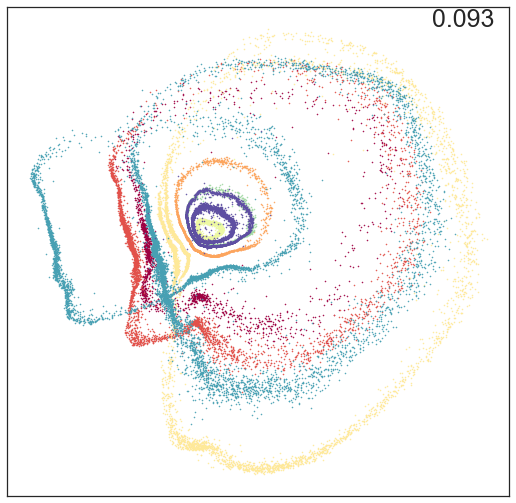

In [220]:
sns.set(style='white', context='notebook', rc={'figure.figsize':(9,9)})
colors = plt.cm.Spectral(np.linspace(0,1,8))
frame1 = plt.gca()
frame1.axes.get_xaxis().set_visible(False)
frame1.axes.get_yaxis().set_visible(False)
plt.title('{0:.3f}'.format(allErrors[5]), loc = 'right', y=1.0, x = 0.97, pad=-20, fontsize = 25)
for sub in range(len(indices)-1):
    plt.scatter(allReps[5][indices[sub]:indices[sub+1],0], y = allReps[5][indices[sub]:indices[sub+1],1], label = sub+1, alpha = 1, s = 0.3, color = colors[sub])
#plt.legend(fontsize = 25, markerscale=50, loc = 'right')
#plt.legend(bbox_to_anchor=(1.6, 5.85), fontsize = 25, markerscale=50, loc='upper right', ncol=1)
plt.savefig('figs/BestMove-Ind.png')

In [218]:
indices

array([    0,  1590,  4993,  6948, 12093, 17937, 19189, 27073, 35396],
      dtype=int32)

## Pose Autoencoder

In [97]:
from sklearn import svm

input_dim = 14
latent_dim = 2
allReps2 = []
allErrors2 = []

for r in range(10):
    #create encoder given input shape
    encoder = create_pose_encoder(latent_dim, input_dim)

    #initialize inputs
    signal_in = Input(shape=input_dim)

    reconstructed_signal, encoded_repr, _ = encoder(signal_in)

    autoencoder = Model(signal_in, [reconstructed_signal])
    autoencoder.compile(loss='mse', optimizer='Adam')

    #Train model on both datasets
    batches = 8000
    batch_size=32

    losses = []
    losses_val = []

    pbar = tqdm(range(batches))
    for _ in pbar:
        ids = np.random.randint(0, x_train_flat[:,0,:-1].shape[0], batch_size)
        x_signals = x_train_flat[ids,0,:-1]
        y_signals = x_signals

        encoder_loss = autoencoder.train_on_batch(x_signals, y_signals)
        losses.append(encoder_loss)

        val_loss = autoencoder.test_on_batch(x_signals, y_signals)
        losses_val.append(val_loss)

    (dec, rep, error) = encoder.predict(x_train_flat[:,0,:-1])


    labels = np.empty((0))
    for ind in range(len(x_train)):
        labels = np.concatenate([labels, np.full(x_train[ind].shape[0], ind)])

    clf = svm.SVC()
    clf.fit(rep, labels)

    preds = clf.predict(rep)

    errorIdx = []
    errorCount = 0
    for p in range(preds.shape[0]):
        if preds[p] != labels[p]:
            errorCount += 1
            errorIdx.append(p)

    print(errorCount / labels.shape[0])
    allErrors2.append(errorCount / labels.shape[0])
    allReps2.append(rep)

  0%|                                                                                         | 0/8000 [00:00<?, ?it/s]

0.48756921686066224


  0%|                                                                                         | 0/8000 [00:00<?, ?it/s]

0.4972878291332354


  0%|                                                                                         | 0/8000 [00:00<?, ?it/s]

0.5179116284325912


  0%|                                                                                         | 0/8000 [00:00<?, ?it/s]

0.4774550796700192


  0%|                                                                                         | 0/8000 [00:00<?, ?it/s]

0.46745394959882475


  0%|                                                                                         | 0/8000 [00:00<?, ?it/s]

0.48423550683693073


  0%|                                                                                         | 0/8000 [00:00<?, ?it/s]

0.45728330884845747


  0%|                                                                                         | 0/8000 [00:00<?, ?it/s]

0.4641767431348175


  0%|                                                                                         | 0/8000 [00:00<?, ?it/s]

0.5495253700983161


100%|█████████████████████████████████████████████████████████████████████████████| 8000/8000 [01:06<00:00, 119.94it/s]


0.4835574641202396


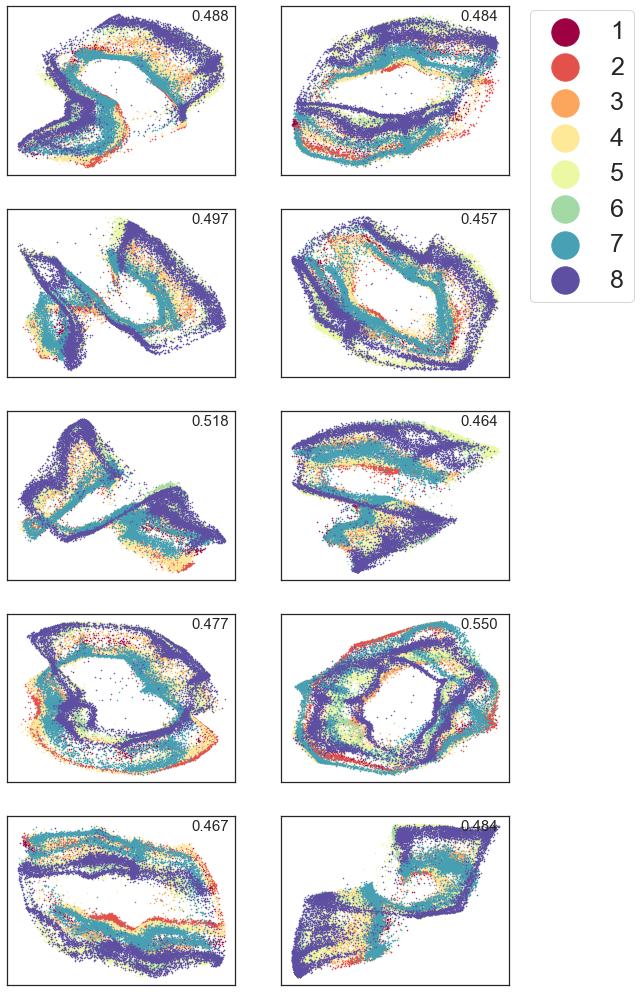

In [202]:
sns.set(style='white', context='notebook', rc={'figure.figsize':(9,18)})
fig, axs = plt.subplots(5,2)
colors = plt.cm.Spectral(np.linspace(0,1,8))
for r in range(5):
    axs[r,0].set_title('{0:.3f}'.format(allErrors2[r]), loc = 'right', y=1.0, x = 0.97, pad=-14, fontsize = 15)
    axs[r,0].get_xaxis().set_visible(False)
    axs[r,0].get_yaxis().set_visible(False)
    for sub in range(len(indices)-1):
        axs[r,0].scatter(allReps2[r][indices[sub]:indices[sub+1],0], y = allReps2[r][indices[sub]:indices[sub+1],1], label = sub+1, alpha = 1, s = 0.3, color = colors[sub])
for r in range(5):
    axs[r,1].set_title('{0:.3f}'.format(allErrors2[r+5]), loc = 'right', y=1.0, x = 0.95, pad=-14, fontsize = 15)
    axs[r,1].get_xaxis().set_visible(False)
    axs[r,1].get_yaxis().set_visible(False)
    for sub in range(len(indices)-1):
        axs[r,1].scatter(allReps2[r+5][indices[sub]:indices[sub+1],0], y = allReps2[r+5][indices[sub]:indices[sub+1],1], label = sub+1, alpha = 1, s = 0.3, color = colors[sub])
#plt.legend(fontsize = 25, markerscale=50, loc = 'right')
plt.legend(bbox_to_anchor=(1.6, 5.85), fontsize = 25, markerscale=50, loc='upper right', ncol=1)
plt.savefig('figs/PoseAE-10runs-IndColor.png')

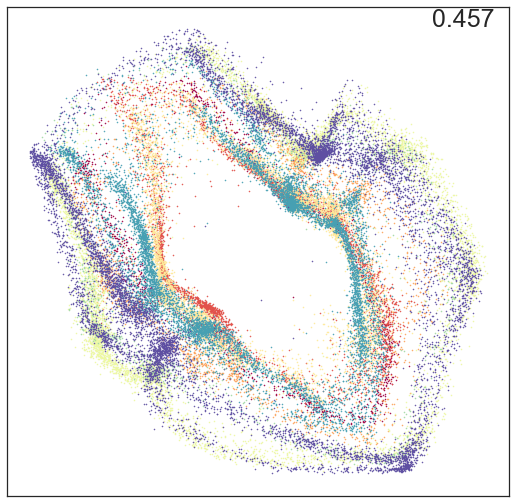

In [222]:
sns.set(style='white', context='notebook', rc={'figure.figsize':(9,9)})
colors = plt.cm.Spectral(np.linspace(0,1,8))
frame1 = plt.gca()
frame1.axes.get_xaxis().set_visible(False)
frame1.axes.get_yaxis().set_visible(False)
plt.title('{0:.3f}'.format(allErrors2[6]), loc = 'right', y=1.0, x = 0.97, pad=-20, fontsize = 25)
for sub in range(len(indices)-1):
    plt.scatter(allReps2[6][indices[sub]:indices[sub+1],0], y = allReps2[6][indices[sub]:indices[sub+1],1], label = sub+1, alpha = 1, s = 0.3, color = colors[sub])
#plt.legend(fontsize = 25, markerscale=50, loc = 'right')
#plt.legend(bbox_to_anchor=(1.6, 5.85), fontsize = 25, markerscale=50, loc='upper right', ncol=1)
plt.savefig('figs/BestPose-Ind.png')

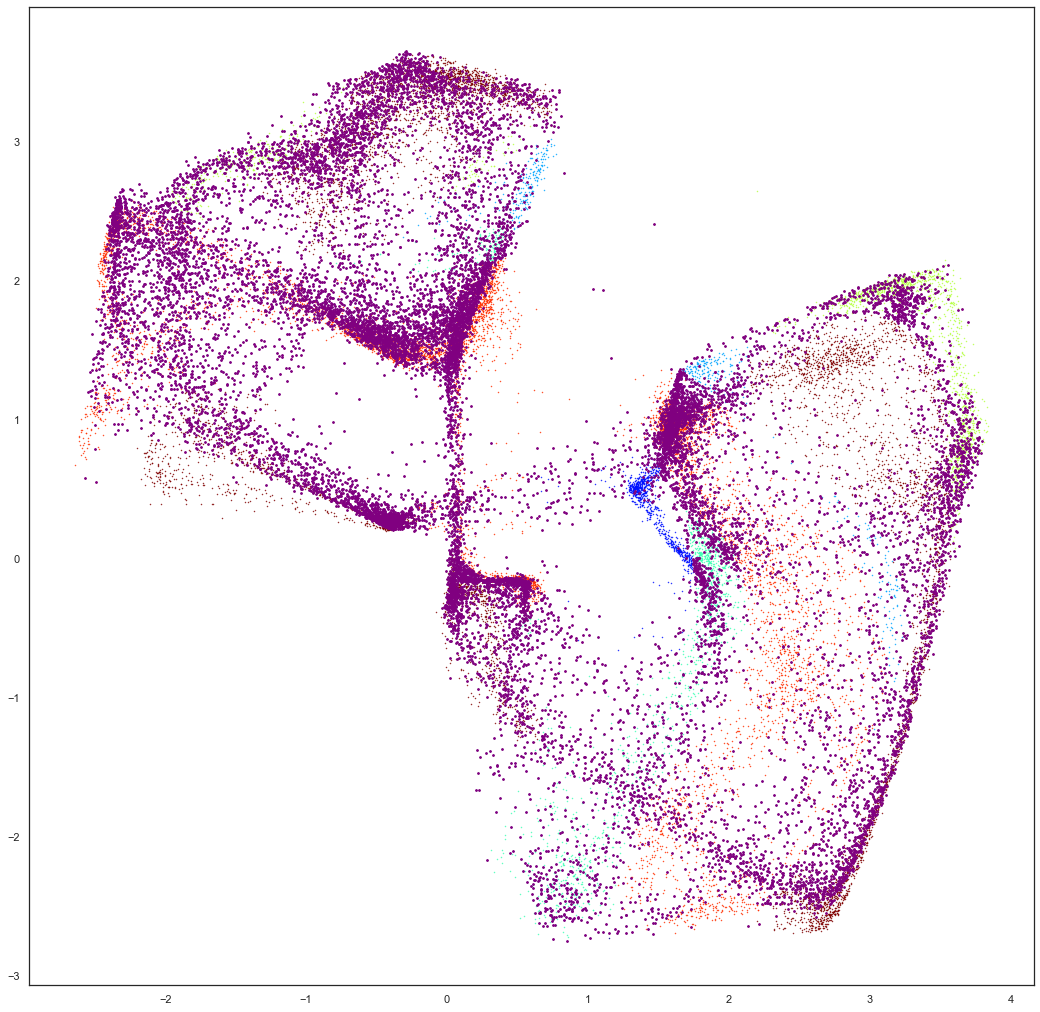

In [127]:
colors = plt.cm.jet(np.linspace(0,1,8))
for ind in range(len(x_train)):
    (dec, rep, error) = encoder.predict(x_train[ind][:,0,:])
    plt.scatter(rep[:,0], rep[:,1], s=0.2, color = colors[ind])
(dec, rep, error) = encoder.predict(x_train_flat[:,0,:])
plt.scatter(rep[errorIdx,0], rep[errorIdx,1], s = 3, color = 'purple')

## PCA

In [129]:
from sklearn.decomposition import PCA # for PCA calculation

pca_vaf_train = []
pca_vaf_test = []
pca_reconLoss = []
pca = PCA()

rep = pca.fit_transform(x_train_flat[:,0,:-1])
y_pca = pca.inverse_transform(rep)

from sklearn import svm

labels = np.empty((0))
for ind in range(len(x_train)):
    labels = np.concatenate([labels, np.full(x_train[ind].shape[0], ind)])
    
clf = svm.SVC()
clf.fit(rep[:,:2], labels)

preds = clf.predict(rep[:,:2])

errorIdx = []
errorCount = 0
for p in range(preds.shape[0]):
    if preds[p] != labels[p]:
        errorCount += 1
        errorIdx.append(p)

print(errorCount / labels.shape[0])

0.6200050831662478


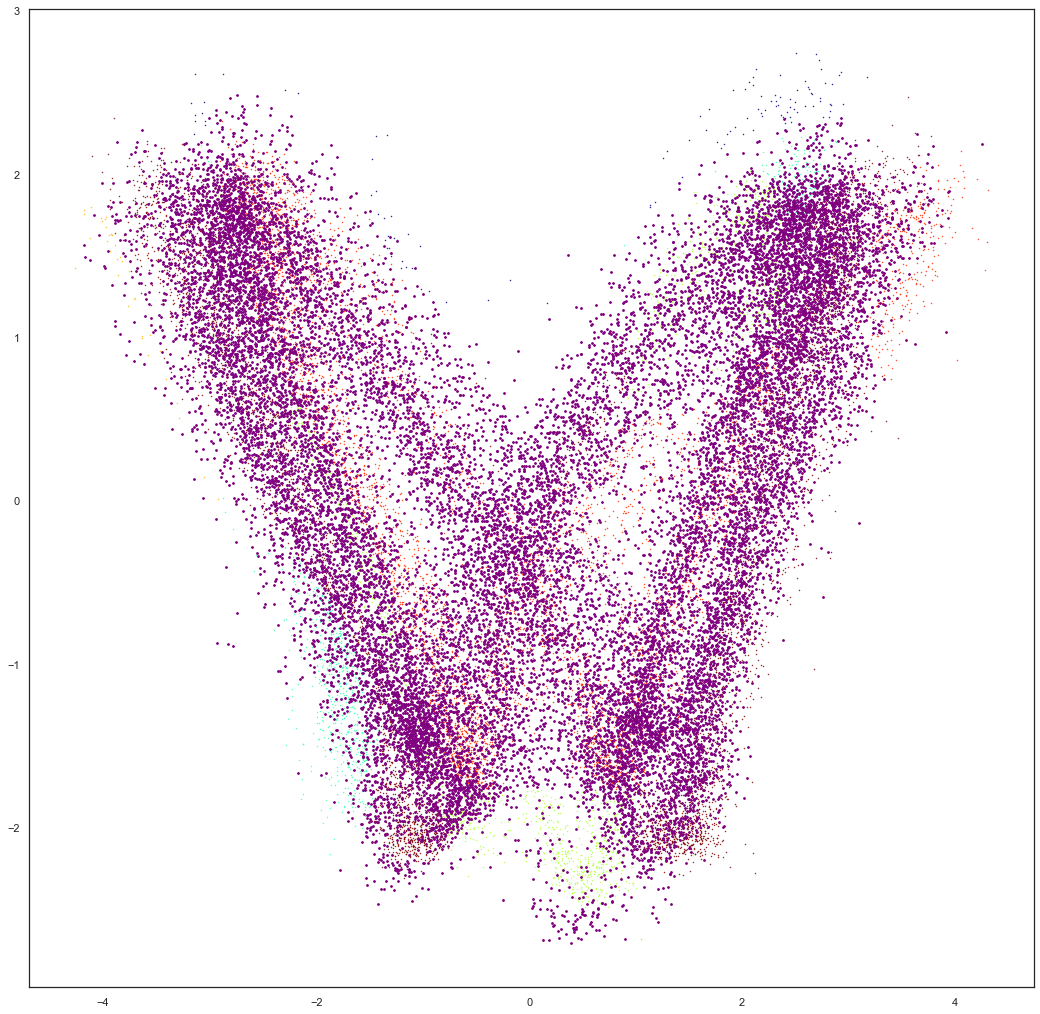

In [131]:
from sklearn.decomposition import PCA # for PCA calculation

pca = PCA()

rep = pca.fit_transform(x_train_flat[:,0,:-1])

sns.set(style='white', context='notebook', rc={'figure.figsize':(5,5)})

plt.scatter(rep[:x_train_flat.shape[0],0], rep[:x_train_flat.shape[0],1], alpha = 1, s = 0.3, color = 'blue')
plt.scatter(rep[x_train_flat.shape[0]:,0], rep[x_train_flat.shape[0]:,1], alpha = 1, s = 0.3, color = 'red')
plt.title('{0:.3f}'.format(0.620005), loc = 'right', y=1.0, x = 0.95, pad=-14, fontsize = 15)

frame1 = plt.gca()
frame1.axes.get_xaxis().set_visible(False)
frame1.axes.get_yaxis().set_visible(False)
plt.savefig('figs/PCA-1runs-MoveColor.png')

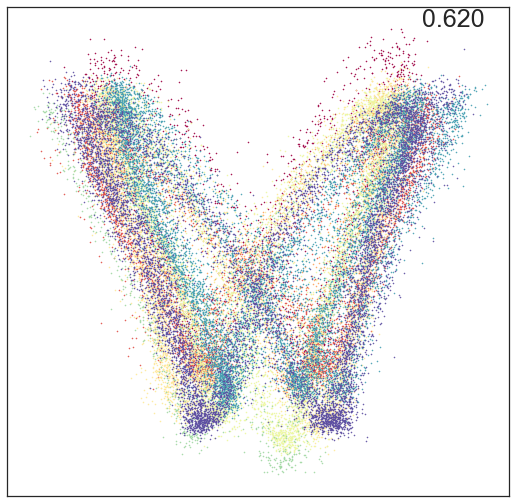

In [225]:
from sklearn.decomposition import PCA # for PCA calculation

pca = PCA()

rep = pca.fit_transform(x_train_flat[:,0,:-1])

sns.set(style='white', context='notebook', rc={'figure.figsize':(9,9)})
for sub in range(len(indices)-1):
        plt.scatter(rep[indices[sub]:indices[sub+1],0], y = rep[indices[sub]:indices[sub+1],1], label = sub+1, alpha = 1, s = 0.3, color = colors[sub])
plt.title('{0:.3f}'.format(0.620005), loc = 'right', y=1.0, x = 0.95, pad=-20, fontsize = 25)

frame1 = plt.gca()
frame1.axes.get_xaxis().set_visible(False)
frame1.axes.get_yaxis().set_visible(False)
plt.savefig('figs/PCA-1runs-IndColor.png')

## Individual identification figure

Kolmogorov-Smirnov statistic returns p value of: 0.00001


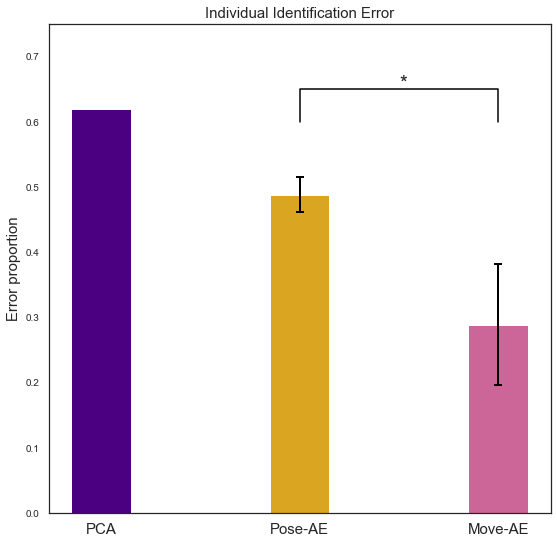

In [242]:
from scipy import stats


heights = [0.6200, np.mean(allErrors2), np.mean(allErrors)]
stds = [0, np.std(allErrors2), np.std(allErrors)]
plt.ylim(0,0.75)
plt.bar('PCA', heights[0], width = 0.3, align='center', color = 'indigo');
plt.bar('Pose-AE', heights[1], width = 0.3, align='center', color = 'goldenrod');
plt.bar('Move-AE', heights[2], width = 0.3, align='center', color = (0.8,0.4,0.6));
plt.errorbar([1,2], heights[1:], stds[1:], capsize = 4, capthick = 2, linewidth = 2, linestyle='None', color = 'black', barsabove =False);
plt.xticks(fontsize=15);
plt.yticks(fontsize=10);
plt.ylabel('Error proportion', fontsize = 15)
plt.title('Individual Identification Error', fontsize = 15)

plt.plot([1, 1, 2, 2], [0.6, 0.65, 0.65, 0.6], color = 'black')
plt.annotate('*', (1.5, 0.65), fontsize = 20)

stat, pvalue = stats.ks_2samp(allErrors, allErrors2)
print('Kolmogorov-Smirnov statistic returns p value of: ' + '{0:.5f}'.format(pvalue))
#plt.savefig('figs/Barchart-Ind')

In [243]:
print(heights)
print(stds)

[0.62, 0.4886456096734094, 0.28891965193807206]
[0, 0.02615466240553725, 0.09264708238044107]
